## Create Images.

Using a class to create images from the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) based on the maximum imagesize given by 'get_largest_dimension.py' of 3264.  I have set my image generators to only keep images of a specified size, picsize.

In [1]:
from dog_images import DogImages

picsize = 16*2

# three for testing purposes
lst_dogs = ['n02085620-Chihuahua', 
            'n02085782-Japanese_spaniel',
            'n02085936-Maltese_dog',
            'n02086079-Pekinese',
            'n02086240-Shih-Tzu']
dog_images = DogImages(lst_dogs, picsize)
dog_images.generate_img_files()
train_imgs = dog_images.load_images('train')
test_imgs = dog_images.load_images('test')
Xtest = test_imgs[0]
Ytest = test_imgs[1]
Xtrain = train_imgs[0]
Ytrain = train_imgs[1]

In [2]:
import numpy as np
Xhold = Xtrain.copy()
Yhold = Ytrain.copy()
new = np.array([i for i in range(Xhold.shape[0])])
np.random.shuffle(new)
for i, n in enumerate(new):
    Xtrain[i, :] = Xhold[n, :]
    Ytrain[i, :] = Yhold[n, :]
    
Xhold = Xtest
Yhold = Ytest
new = np.array([i for i in range(Xhold.shape[0])])
np.random.shuffle(new)
for i, n in enumerate(new):
    Xtest[i, :] = Xhold[n, :]
    Ytest[i, :] = Yhold[n, :]

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
x = tf.placeholder(tf.float32, shape=[None, picsize*picsize*3], name='X')

# When passing through the network, we want to represent the images
# as a 4-tensor: (n_images, image_height, image_width, n_channels)
x_image = tf.reshape(x, [-1, picsize, picsize, 3], name='ximage')

(1464, 32, 32, 3)


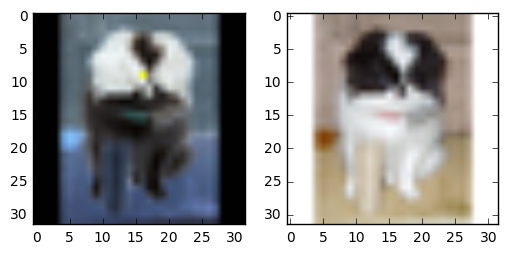

In [5]:
sess = tf.InteractiveSession()
# with tf.Session() as sess:
# Initialize everything and prepare for training.
sess.run(tf.global_variables_initializer())
print(x_image.eval(feed_dict={x:Xtrain}).shape)
img = x_image[0].eval(feed_dict={x:Xtrain})
fig, axes = plt.subplots(1, 2)
ax=list(axes.flatten())
ax[0].imshow(img)
ax[0].grid(False)
ax[1].imshow(Image.fromarray(np.uint8(img)))
ax[1].grid(False)
plt.show()

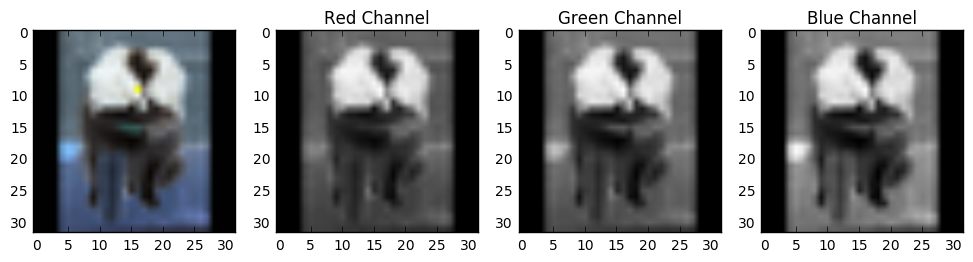

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(12, 8))

axs[0].imshow(img)
axs[0].grid(False)
for i in range(1, 4):
    axs[i].imshow(img[:, :, i-1], cmap=plt.cm.gray_r)
    axs[i].set_title("{} Channel".format(["Red", "Green", "Blue"][i-1]))
plt.show()

In [7]:
print("Total Data Set Shape: {}".format(x_image.eval(feed_dict={x:Xtrain}).shape))

Total Data Set Shape: (1464, 32, 32, 3)


## Single layer network...
A fully connected network with no hidden layers

![Fully Connected Network With No Hidden Layers](WebImages\fully_connected.png)

In [8]:
# Placeholder for the input data.
x = tf.placeholder(tf.float32, [None, picsize * picsize * 3])
# Placeholder for input class labels.
y = tf.placeholder(tf.float32, [None, len(lst_dogs)])

# Weights.  There are len(lst_dogs) output classes, and one weight per (pixel, output class)
# combination.
W = tf.Variable(tf.truncated_normal([picsize * picsize * 3, len(lst_dogs)], stddev=0.1), name='W')

# Biasies.  This is like an intercept term in a linear regression.  There is one
# per output class.
b = tf.Variable(tf.truncated_normal([len(lst_dogs)], stddev=0.001), name='b')

# Output layer, probabilities of each class.
y_hat = tf.nn.softmax(tf.matmul(x, W) + b)

# Our loss function.
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat))

# Evaluate the classification accuracy.  What percentage of the test images were
# correctly classified.
prediction = tf.argmax(y_hat, 1)
correct_prediction = tf.equal(prediction, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
# Train the model by gradient descent, for a fixed 1000 iterations.
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(cross_entropy)

tf.global_variables_initializer().run()
slides = int(Xtrain.shape[0]/100)
epochs = int(Xtrain.shape[0]/slides)
for step in range(epochs):
    batch_xs = Xtrain[i*slides:i*slides + slides - 1] 
    batch_ys = Ytrain[i*slides:i*slides + slides - 1]
    for _ in range(10):
        sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
    print('\r Percent Complete: {:.2f}% - Accuracy {:.2f}%'.format(100*(step+1)/epochs, 
                                                                   accuracy.eval(feed_dict={x: Xtest, y: Ytest})*100), end='')
print()
print("Test Error Accuracy: {:0.2f}%".format(100*sess.run(accuracy, feed_dict={x: Xtest, y: Ytest})))
save_W = W.eval()

 Percent Complete: 100.00% - Accuracy 24.32%
Test Error Accuracy: 24.32%


Not the best.  We need some hidden layers.  But first, I want to see *eigenpuppies*:

In [10]:
from math import sqrt

def plot_digit_weights(ax, image, convert=False): 
    """Plot the weights from our fit fully connected network as an image."""
    size = image.shape[0]
    n = int(sqrt(size/3))
    img = image.reshape(n,n,3)
#     if convert==True:
#         img = Image.fromarray(np.uint8(img))
    ax.imshow(img)

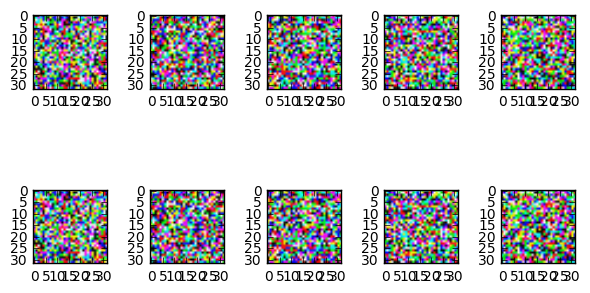

In [11]:

fig, axs = plt.subplots(2, len(lst_dogs))
for n, ax in enumerate(axs.flatten()):
    if n<= len(lst_dogs) - 1:
        plot_digit_weights(ax, save_W[:,n])
    else:
        a = n - len(lst_dogs)
        plot_digit_weights(ax, save_W[:,a], True)
plt.tight_layout()
plt.show()

In [12]:
sess.close()

## Single hidden Layer
Trying with a single hidden layer...

![Single Hidden Layer](WebImages/single_layer.png)

Where N is somenumber of hidden features...

In [13]:

for N in range(len(lst_dogs), len(lst_dogs)*11, len(lst_dogs)):
    # Set-Up
    y = tf.placeholder(tf.float32, [None, len(lst_dogs)])
    # three channels, picsize of picsize
    X = tf.placeholder(tf.float32, [None, picsize*picsize*3])

    # Weights & bias...
    W1 = tf.Variable(tf.truncated_normal([picsize*picsize*3, N], stddev=0.1), name='W1')
    b1 = tf.Variable(tf.truncated_normal([N,], stddev=0.1), name='b1')
    
    # Run it...
    X1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    
    # Weights & bias...
    W2 = tf.Variable(tf.truncated_normal([N, len(lst_dogs)], stddev=0.1), name='W2')
    b2 = tf.Variable(tf.truncated_normal([len(lst_dogs),], stddev=0.1), name='b2')

    # Math
    y_hat = tf.nn.softmax(tf.matmul(X1, W2) + b2)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat))
    loss_function = cross_entropy + 0.001 * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)) 
    prediction = tf.argmax(y_hat, axis=1)
    correct_prediction = tf.equal(prediction, tf.argmax(y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype='float32'))
    
    # Run it...
    LEARNING_RATE = 0.01
    train_minimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss_function)
    print('\r Percent Complete: {:.2f}% - Accuracy {:.2f}% '.format(0.0, 0.0), end='')

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        slides = len(lst_dogs)*2
        num_batches =  Xtrain.shape[0]/slides
        for step in range(int(num_batches)):
            xbatch = Xtrain[i*slides:i*slides + slides - 1] 
            ybatch = Ytrain[i*slides:i*slides + slides - 1]
            for _ in range(2):
                sess.run(train_minimizer, {X : xbatch, y : ybatch})
            y_pred = sess.run(y_hat, {X: Xtest})
            prediction = tf.argmax(y_pred, axis=1)
            correct_prediction = tf.equal(prediction, tf.argmax(Ytest, axis=1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype='float32'))
            print('\r Percent Complete: {:.2f}% - Accuracy {:.2f}%'.format(100*(step+1)/num_batches, accuracy.eval()*100), end='')
        ans = tf.argmax(Ytest, axis=1).eval()
        pred = prediction.eval()
        print('\r {}'.format(' '*50), end='')
        print('Accuracy for N = {}: {:.2f}%'.format(N, accuracy.eval()*100))
        save_W = W.eval()

                                                   Accuracy for N = 5: 1.14%
                                                   Accuracy for N = 10: 38.18%
                                                   Accuracy for N = 15: 38.18%
                                                   Accuracy for N = 20: 38.18%
                                                   Accuracy for N = 25: 25.00%
                                                   Accuracy for N = 30: 38.18%
                                                   Accuracy for N = 35: 25.00%
                                                   Accuracy for N = 40: 38.18%
                                                   Accuracy for N = 45: 9.55%
                                                   Accuracy for N = 50: 26.14%


## Convoluted Neural Network
Now to create a convoluted neural network.  Setting it up to use variables, so I can reconstruct it as a class (using sklearn methods) and grid search it to find the best parameters for the situation.

![Convolutional Neural Network](WebImages/fully_connected_cnn.png)

In [14]:
out_channels = len(lst_dogs)*8
out_channels_2 = len(lst_dogs)*16
hidden_units = 512*3
regularization_strength = 1.0
batch_steps = 2
slides = len(lst_dogs)*10
learning_rate = 1.0
convolution_size = 5
pool_size = 2
accuracy_counter = 3
accuracy_threshold = 0.1
batch_steps = 99

In [15]:

# convolutional layer
# third number = channels, so 3
W1 = tf.Variable(tf.truncated_normal(shape=[convolution_size, convolution_size, 3, out_channels], stddev=0.1), name='W1')
b1 = tf.Variable(tf.constant(0.1, shape=[out_channels]), name='b1')

# need my x stuff...
# Tensors representing our input dataset and our input labels
x = tf.placeholder(tf.float32, shape=[None, picsize*picsize*3], name='X')
y = tf.placeholder(tf.float32, shape=[None, len(lst_dogs)], name='y')

# When passing through the network, we want to represent the images
# as a 4-tensor: (n_images, image_height, image_width, n_channels)
x_image = tf.reshape(x, [-1, picsize, picsize, 3], name='ximage')

# now the convolution, turns W1/x_m
'''Given an input tensor of shape [batch, in_height, in_width, in_channels] 
and a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]'''
conv1 = tf.nn.conv2d(x_image, W1,
                     strides=[1, 1, 1, 1],
                     padding='SAME', name='conv1')
# [batch, out_height, out_width, filter_height * filter_width * in_channels]
# so [?, out_height, out_width, 75]
relu1 = tf.nn.relu(conv1 + b1)  # shape [?, picsize, picsize, out_channels]

In [16]:
# Step 2: a 2x2 Max Pool 'Layer'
# ksize is the size of the windows to overlay.
# strides controls how to slide the windows around the image.
layer_1_out = tf.nn.max_pool(relu1,
                             ksize=[1, pool_size, pool_size, 1],
                             strides=[1, pool_size, pool_size, 1],
                             padding='SAME')
# size = [?, picsize/2, picsize/2, out_channles]

In [17]:

# convolutional layer  2
W2 = tf.Variable(tf.truncated_normal(shape=[convolution_size, convolution_size, out_channels, out_channels_2], stddev=0.1), name='w2')
b2 = tf.Variable(tf.constant(0.1, shape=[out_channels_2]))

# now the convolution... on layer_1_out
conv2 = tf.nn.conv2d(layer_1_out, W2,
                     strides=[1, 1, 1, 1],
                     padding='SAME', name='conv2')
relu2 = tf.nn.relu(conv2 + b2)
# size of both above: (?, picsize/2, picsize/2, out_channels_2)

layer_2_out = tf.nn.max_pool(relu2,
                         ksize=[1, pool_size, pool_size, 1],
                         strides=[1, pool_size, pool_size, 1],
                         padding='SAME')
# size of both above: (?, picsize/4, picsize/4, out_channels_2)

In [18]:
# A fully connected layer, this time with 512 hidden units (coming from 38x38x48 inputs). 
# Use ReLU activation.

Wf = tf.Variable(tf.truncated_normal(shape=[int(picsize**2 * 1/16 * out_channels_2), hidden_units], stddev=0.01))

bf = tf.Variable(tf.constant(0.1, shape=[hidden_units]))

# Flatten the output of the second layer.  This allows us to do
# a simple matrix multiplication with the weight matrix for the
# fully connected layer.
layer_2_out_flat = tf.reshape(layer_2_out, [-1, int(picsize**2 * 1/16 * out_channels_2)])

fully_connected_1_out = tf.nn.relu(tf.matmul(layer_2_out_flat, Wf) + bf)
# size: ?, hidden_units

In [19]:
Wf2 = tf.Variable(tf.truncated_normal(shape=[hidden_units, len(lst_dogs)], stddev=0.01))
bf2 = tf.Variable(tf.constant(0.1, shape=[len(lst_dogs)]))

# The output layer
# Predictions, but on a log-odds scale.
fully_connected_2_out = tf.matmul(fully_connected_1_out, Wf2) + bf2
# shape: inputs, # classes

In [20]:
#Training & Loss Function

# The basic loss function, cross entropy.
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=fully_connected_2_out))

# Use L2 regularization on all the weights in the network.

regularization_term = regularization_strength * (
    tf.nn.l2_loss(W1) +
    tf.nn.l2_loss(W2) +
    tf.nn.l2_loss(Wf) +
    tf.nn.l2_loss(Wf2)
)

# The total loss function we will minimize is cross entropy
# plus regularization.
total_loss = cross_entropy + regularization_term

In [21]:
import math

# Training...
# ADAM is a sophisticated version of gradient descent that adapts the
# learning rate over time.
train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

# Create a tensor to track the accuracy during training.
correct_prediction = tf.equal(tf.argmax(fully_connected_2_out, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


sess = tf.InteractiveSession()
# with tf.Session() as sess:
# Initialize everything and prepare for training.
sess.run(tf.global_variables_initializer())
# Run the gradient descent, printing out the training and
# testing accuracy every 100 iterations.
train_accuracies, test_accuracies, test_x = [0.0], [0.0], [0.0]
training_epochs = int((Xtrain.shape[0])/slides)
print('{} Slides per epoch for {} training epochs'.format(slides, training_epochs))
print('\rPercent Complete: {:.2f}% - Accuracy: {:.2f}%'.format(0, 0), end='')

for i in range(training_epochs):
    # while i <= training_epochs and not math.isnan(last_accuracy):
    xbatch = Xtrain[i*slides:i*slides + slides - 1] 
    ybatch = Ytrain[i*slides:i*slides + slides - 1]
    
    # go until the accuracy is stable...
    train_accuracy = -10
    dif = 9000
    steps = 0
    while dif > accuracy_threshold or steps <= batch_steps:
        old = train_accuracy
        train_step.run(feed_dict={x: xbatch, y: ybatch})
        train_accuracy = accuracy.eval(feed_dict={x:xbatch, y: ybatch})
        dif = train_accuracy - old
        steps += 1
        
    # Print out diagnostics
    train_accuracy = accuracy.eval(feed_dict={x:xbatch, y: ybatch})
    train_accuracies.append(train_accuracy)
    if i % accuracy_counter == 0:
        test_accuracy = accuracy.eval(feed_dict={x:Xtest, y: Ytest})
        test_accuracies.append(test_accuracy)
        test_x.append(len(train_accuracies))
    print('\rPercent Complete: {:.1f}% - Accuracy: {:.1f}%'.format(100.0*float((i+1)/training_epochs), 
                                                                   100*test_accuracies[-1]), end='')
    train_accuracies.append(train_accuracy)
print()
print('DING! Your CNN is ready.')
test_accuracy = accuracy.eval(feed_dict={x:Xtest, y: Ytest})
test_accuracies.append(test_accuracy)
test_x.append(len(train_accuracies))
print('Accuracy = {:.1f}%'.format(100*test_accuracy))


50 Slides per epoch for 29 training epochs
Percent Complete: 100.0% - Accuracy: 25.0%
DING! Your CNN is ready.
Accuracy = 25.0%


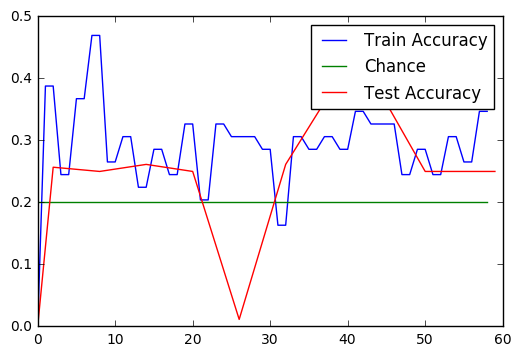

In [22]:
plt.plot(list(range(len(train_accuracies))), train_accuracies, label='Train Accuracy')
plt.plot(list(range(len(train_accuracies))),np.ones(len(train_accuracies))*1/len(lst_dogs), label='Chance')
plt.plot(test_x, test_accuracies, label='Test Accuracy')
plt.legend()
plt.show()

## Convert to a Class Object

In [ ]:
from image_classifier import ImageClassifier

model = ImageClassifier(picsize, lst_dogs,
                         out_channels=len(lst_dogs)*3*8,
                         out_channels_2=len(lst_dogs)*6*8,
                         hidden_units =3*8*len(lst_dogs),
                         regularization_strength=1.0,
                         slides=len(lst_dogs)*10,
                         learning_rate=0.001,
                         convolution_size=5,
                         pool_size=2,
                         accuracy_counter=3,
                         accuracy_thresh=0.01,
                         runs=99,
                         verbose=True)

In [ ]:
model.fit(Xtrain, Ytrain)
model.score(Xtest, Ytest)

50 Slides per epoch for 29 training epochs
Percent Complete: 0.00% - Accuracy: 0.00%